# Tarea 08 -  Clasificación Telco

## Objetivo del problema

Desarrollar un modelo de clasificación binaria basado en Deep Learning capaz de predecir la probabilidad de deserción de clientes (Churn) en una empresa de telecomunicaciones, utilizando información histórica relacionada con características demográficas, servicios contratados, condiciones contractuales, permanencia del cliente y cargos económicos.

El modelo tendrá como objetivo identificar si un cliente abandonará el servicio (Churn = 1) o permanecerá activo (Churn = 0), permitiendo comprender los patrones y factores que influyen en la decisión de abandono. Esta predicción busca apoyar la toma de decisiones estratégicas, facilitando la implementación de acciones preventivas de retención y optimizando la gestión de clientes con alto riesgo de churn.

La siguiente tabla contiene la información del conjunto de datos que será utilizado para crear nuestro modelos de DL


  | Columna          | Tipo lógico | Observación                            |
  | ---------------- | ----------- | -------------------------------------- |
  | tenure           | Numérica    | Meses de permanencia                   |
  | MonthlyCharges   | Numérica    | Cargo mensual                          |
  | TotalCharges     | Numérica    | Cargo total acumulado                  |
  | gender           | Nominal     | Categoría sin orden                    |
  | SeniorCitizen    | Nominal     | Binaria (0/1), tratada como categórica |
  | Partner          | Nominal     | Sí / No                                |
  | Dependents       | Nominal     | Sí / No                                |
  | PhoneService     | Nominal     | Sí / No                                |
  | MultipleLines    | Nominal     | Sí / No / No phone service             |
  | InternetService  | Nominal     | DSL / Fiber / No                       |
  | OnlineSecurity   | Nominal     | Sí / No / No internet service          |
  | OnlineBackup     | Nominal     | Sí / No / No internet service          |
  | DeviceProtection | Nominal     | Sí / No / No internet service          |
  | TechSupport      | Nominal     | Sí / No / No internet service          |
  | StreamingTV      | Nominal     | Sí / No / No internet service          |
  | StreamingMovies  | Nominal     | Sí / No / No internet service          |
  | PaperlessBilling | Nominal     | Sí / No                                |
  | PaymentMethod    | Nominal     | Método de pago                         |
  | Contract         | Ordinal     | Month-to-month < One year < Two year   |
  | **Churn**        | Nominal     | Variable objetivo (binaria: 1=abandono / 0=fidelidad)  |


In [ ]:
#@title  ## Importando librerias y conjunto de datos

import joblib
import numpy as np
import pandas as pd
import warnings

from pathlib import Path

import tensorflow as tf
from tensorflow import keras


from src.data_processor import DataProcessor, process_new_data_with_artifacts
from src.load_from_zip import load_processed_data_from_zip
from src.save_to_zip import save_processed_data_to_zip
from src.nn_desing import disenar_red_binaria

SEED = 77

np.random.seed(SEED)
tf.random.set_seed(SEED)

datapath = Path().resolve() / 'data'

warnings.filterwarnings('ignore')




## Transformando los datos

Los bloques de esta sección se pueden omitir si ya se tiene los datos procesados

In [ ]:
#@title ### 1. Transformando datos de entrenamiento, prueba y validación
telco_path = datapath / 'telco.csv'
telco_df = pd.read_csv(telco_path)

telco_df.sample(5, random_state=SEED)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2370,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.70,7904.25,0
6804,Male,0,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Bank transfer (automatic),69.85,5102.35,0
1097,Female,0,Yes,Yes,20,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,20.00,417.65,0
525,Male,1,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),115.75,8399.15,0
3755,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),82.65,5919.35,0


In [ ]:
print("Tamaño original de la tabla: ", telco_df.shape)

Tamaño original de la tabla:  (6932, 20)


In [ ]:
telco_config = {
    'target': 'Churn',
    'cols_num': ['tenure', 'MonthlyCharges', 'TotalCharges'],
    'cols_cat': ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                 'PhoneService', 'MultipleLines', 'InternetService',
                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                 'TechSupport', 'StreamingTV', 'StreamingMovies',
                 'PaperlessBilling', 'PaymentMethod','Contract'],
    'cols_onehot': ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                 'PhoneService', 'MultipleLines', 'InternetService',
                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                 'TechSupport', 'StreamingTV', 'StreamingMovies',
                 'PaperlessBilling', 'PaymentMethod'],
    'cols_ordinal': ['Contract'],
    'ordinal_categories': [['Month-to-month', 'One year', 'Two year']],
    'stratify': True
}

processor = DataProcessor(**telco_config)
resultados_telco = processor.process(telco_path)
artifacts = resultados_telco['artifacts']


Resumen del preprocesamiento:
X_train_final: (4436, 44)
X_val_final  : (1109, 44)
X_test_final : (1387, 44)
Total de características: 44
  - Numéricas: 3
  - Categóricas procesadas: 41


In [ ]:
processed_path = datapath / 'processed' / 'telco.zip'
save_processed_data_to_zip(processed_data=resultados_telco,
                           zip_path=processed_path,
                           printpath = True)

Datos procesados guardados en /content/data/processed/telco.zip


## 2. Diseñando el modelo

Para esta parte, se usará el script `clasificación_binaria.ipynb` de la clase que fue copiado y pegado dentro del archivo `nn_desing.py` para facilitar la lectura de este notebook.

In [ ]:
#@title ### 1. Cargando datos procesados


datapath = Path().resolve() / 'data'
processed_zip = datapath / 'processed' / 'telco.zip'


print('-----------------------------')

train_loaded, val_loaded, test_loaded, _, metadata = load_processed_data_from_zip(zip_path=processed_path, prinpath = True)

print('-----------------------------')

X_train = train_loaded.drop(columns = ["target"])
y_train = train_loaded["target"]

X_val = val_loaded.drop(columns = ["target"])
y_val = val_loaded["target"]

X_test = test_loaded.drop(columns= ["target"])
y_test = test_loaded["target"]

print('> El target es: ', metadata['target'])
print("> X_train.shape = ", X_train.shape)
print("> X_val.shape = ", X_val.shape)
print("> X_test.shape = ", X_test.shape)


-----------------------------
Datos extraidos desde /content/data/processed/telco.zip correctamente
-----------------------------
> El target es:  Churn
> X_train.shape =  (4436, 44)
> X_val.shape =  (1109, 44)
> X_test.shape =  (1387, 44)


In [ ]:
def build_binary_mlp(n0: int, capas: list, l2_value: float, dropouts: list, threshold: float = 0.5, lr: float = 1e-3) -> keras.Model:

    assert len(capas) == len(dropouts), "capas y dropouts deben tener la misma longitud"

    if threshold < 0 or threshold > 1:
        raise ValueError("threshold debe estar entre 0 y 1")

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n0,)))

    for units, dr in zip(capas, dropouts):
        model.add(
            keras.layers.Dense(
                units,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(l2_value)
            )
        )
        model.add(keras.layers.Dropout(dr, seed=SEED))

    # salida sigmoide (probabilidad clase 1)
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss="binary_crossentropy",
      metrics=[
          keras.metrics.BinaryAccuracy(name="accuracy", threshold=threshold),
          ]
    )


    return model


In [ ]:
d = X_train.shape[0]
n0 = X_train.shape[1]

print(15*"-")
print(" d = ", d)
print(" n0 = ", n0)
print(15*"-")

diseno = disenar_red_binaria(d, n0)
print(diseno)

---------------
 d =  4436
 n0 =  44
---------------
DisenoRedBinaria(capas=[88, 44, 22, 11], P=9131, rho=0.2058385933273219, l2=8.999999999999999e-05, dropouts=[0.15, 0.1275, 0.105, 0.0825], patience=15, min_delta=0.0001, max_epochs=200)


In [ ]:
capas     = diseno.capas
l2_value  = diseno.l2
dropouts  = diseno.dropouts
patience  = diseno.patience
min_delta = diseno.min_delta
max_epochs= diseno.max_epochs
threshold = 0.75

model = build_binary_mlp(n0=n0, capas=capas, l2_value=l2_value, dropouts=dropouts, threshold=threshold)
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 88)             │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 44)             │         3,916 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 22)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,131 (35.67 KB)

 Trainable params: 9,131 (35.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title ## 3. Entrenar + validar (EarlyStopping)
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=1
    )
]

BATCH_SIZE = 32  # puedes ajustar; lo dejo fijo

history = model.fit(
    X_train.astype(np.float32),
    y_train.values,
    validation_data=(X_val.astype(np.float32), y_val.values),
    epochs=max_epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7308 - loss: 0.6024 - val_accuracy: 0.7349 - val_loss: 0.4452
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7332 - loss: 0.4469 - val_accuracy: 0.7349 - val_loss: 0.4381
Epoch 3/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7388 - loss: 0.4437 - val_accuracy: 0.7376 - val_loss: 0.4351
Epoch 4/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.4367 - val_accuracy: 0.7529 - val_loss: 0.4343
Epoch 5/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.4340 - val_accuracy: 0.7493 - val_loss: 0.4321
Epoch 6/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7602 - loss: 0.4213 - val_accuracy: 0.7529 - val_loss: 0.4336
Epoch 7/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7538 - loss: 0.4254 - val_accuracy: 0.7484 - val_loss: 0.4335
Epoch 8/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7611 - loss: 0.4187 - val_accu

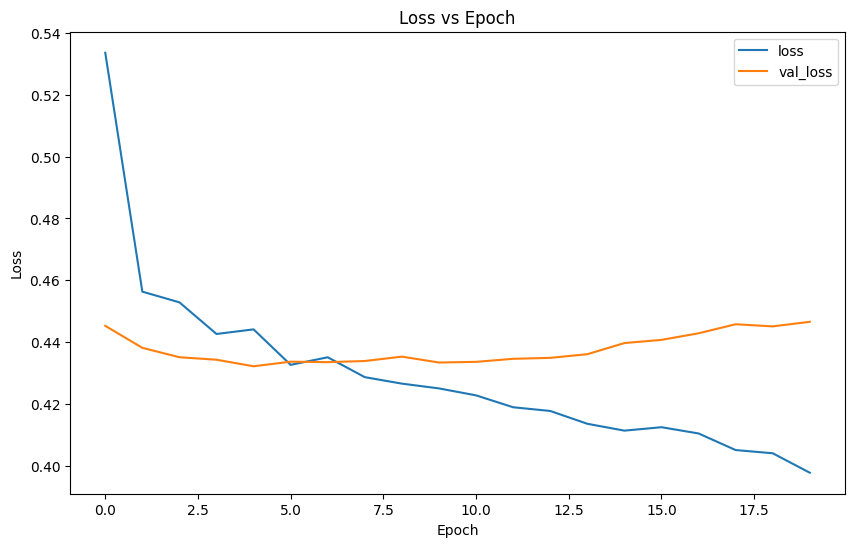

In [ ]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

figure = plt.figure(figsize=(10, 6))
ax = plt.gca()
history_df.plot(y=["loss", "val_loss"], ax=ax)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epoch")

plt.show()


In [ ]:
#@title ## 4. Alpha óptima en validación + métricas finales en test

# ============================================================
#   Configuración de evaluación (simetría vs clase crítica)
# ============================================================
#
# True  -> clases simétricas -> optimizamos Accuracy
# False -> clase 1 crítica   -> optimizamos F1 con Recall mínimo
#
# ============================================================

CLASES_SIMETRICAS = False
RECALL_MIN = 0.75  # solo si CLASES_SIMETRICAS = False


def counts(y, yhat):
    TP = ((y == 1) & (yhat == 1)).sum()
    FP = ((y == 0) & (yhat == 1)).sum()
    TN = ((y == 0) & (yhat == 0)).sum()
    FN = ((y == 1) & (yhat == 0)).sum()
    return int(TP), int(FP), int(TN), int(FN)

def metrics_from_counts(TP, FP, TN, FN):
    denom = TP + TN + FP + FN
    acc = (TP + TN) / denom if denom else 0.0
    rec = TP / (TP + FN) if (TP + FN) else 0.0
    f1  = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) else 0.0
    return float(acc), float(rec), float(f1)

def print_confusion_matrix(TP, FP, TN, FN, *, title="Matriz de confusión"):
    # Formato estándar:
    #            Pred 0     Pred 1
    # True 0       TN        FP
    # True 1       FN        TP
    print(f"\n{title}:")
    print("            Pred 0     Pred 1")
    print(f"True 0     {TN:8d}  {FP:8d}")
    print(f"True 1     {FN:8d}  {TP:8d}")

# ---- 6.1) Buscar alpha óptima en VALIDACIÓN ----
p_val = model.predict(X_val.astype(np.float32), verbose=0).ravel()

ALPHA_GRID = np.linspace(0.0, 1.0, 2001)  # paso 0.0005

best_alpha = None
best_val = -1.0

fallback_alpha = None
best_recall = -1.0

for a in ALPHA_GRID:
    yhat_val = (p_val >= a).astype(int)

    TP, FP, TN, FN = counts(y_val.values, yhat_val)
    acc, rec, f1 = metrics_from_counts(TP, FP, TN, FN)

    if CLASES_SIMETRICAS:
        # clases simétricas -> max accuracy
        if acc > best_val:
            best_alpha, best_val = float(a), float(acc)
    else:
        # clase 1 crítica -> max F1 con recall mínimo
        if rec >= RECALL_MIN and f1 > best_val:
            best_alpha, best_val = float(a), float(f1)

        # fallback: el que logre el mejor recall aunque no cumpla el mínimo
        if rec > best_recall:
            fallback_alpha, best_recall = float(a), float(rec)

ALPHA = best_alpha if best_alpha is not None else fallback_alpha

# ---- Mensajes obligatorios solicitados ----
metric_principal = "Accuracy" if CLASES_SIMETRICAS else "F1"

print("\n=== Configuración de decisión (binaria) ===")
print("Métrica principal:", metric_principal)
print("¿Clase positiva (1) crítica?:", (not CLASES_SIMETRICAS))
if not CLASES_SIMETRICAS:
    print("Recall mínimo exigido:", RECALL_MIN)
print("Alpha empleado (umbral):", ALPHA)

# ---- 6.2) Métricas finales en TEST usando ALPHA ----
p_test = model.predict(X_test.astype(np.float32), verbose=0).ravel()
yhat_test = (p_test >= ALPHA).astype(int)

TP, FP, TN, FN = counts(y_test.values, yhat_test)
acc, rec, f1 = metrics_from_counts(TP, FP, TN, FN)

test_metrics = {
    "TP": TP, "FP": FP, "TN": TN, "FN": FN,
    "accuracy": acc,
    "recall": rec,
    "f1": f1,
}

print_confusion_matrix(TP, FP, TN, FN, title="Matriz de confusión (TEST)")
# ---- Mostrar métricas como tabla ----
print("\nMétricas en test:")
print("-----------------------------------")
print(f"{'Métrica':<15} | {'Valor':>10}")
print("-----------------------------------")
print(f"{'Accuracy':<15} | {acc:10.4f}")
print(f"{'Recall':<15} | {rec:10.4f}")
print(f"{'F1':<15} | {f1:10.4f}")
print("-----------------------------------")




=== Configuración de decisión (binaria) ===
Métrica principal: F1
¿Clase positiva (1) crítica?: True
Recall mínimo exigido: 0.75
Alpha empleado (umbral): 0.28600000000000003

Matriz de confusión (TEST):
            Pred 0     Pred 1
True 0          774       245
True 1           73       295

Métricas en test:
-----------------------------------
Métrica         |      Valor
-----------------------------------
Accuracy        |     0.7707
Recall          |     0.8016
F1              |     0.6498
-----------------------------------


In [ ]:
#@title ## 5. Guardando el modelo

import os
import json
import zipfile



OUT_DIR = "salida_binaria"
ZIP_NAME = "resultados.zip"

os.makedirs(OUT_DIR, exist_ok=True)

metadata = {
    "n_samples_train": int(d),
    "n_features": int(n0),
    "architecture": capas,
    "l2": float(l2_value),
    "dropouts": dropouts,
    "patience": int(patience),
    "min_delta": float(min_delta),
    "max_epochs": int(max_epochs),

    # --- claves para inferencia universal ---
    "alpha": float(ALPHA),

    # --- decisión / prioridad ---
    "clases_simetricas": bool(CLASES_SIMETRICAS),
    "clase_positiva_critica": bool(not CLASES_SIMETRICAS),
    "metrica_principal": metric_principal,
    "recall_min": None if CLASES_SIMETRICAS else float(RECALL_MIN),

    # --- resultados finales ---
    "metrics_test": test_metrics,
    "confusion_matrix_test": {
        "TN": TN, "FP": FP,
        "FN": FN, "TP": TP
    },
}

with open(os.path.join(OUT_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

# Guardar modelo (ya entrenado)
model_path = os.path.join(OUT_DIR, "modelo.keras")
model.save(model_path)

# Guardar historial de entrenamiento (igual que regresión)
history_path = os.path.join(OUT_DIR, "historial_entrenamiento.csv")
pd.DataFrame(history.history).to_csv(history_path, index=False)

# Empaquetar todo en ZIP
with zipfile.ZipFile(ZIP_NAME, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in [model_path, history_path, os.path.join(OUT_DIR, "metadata.json")]:
        zipf.write(file, arcname=os.path.basename(file))

print(f"\n✔ ZIP generado correctamente: {ZIP_NAME}")


✔ ZIP generado correctamente: resultados.zip


## Clasificando con los datos nuevos

In [ ]:
#@title ### 1. Cargando y procesando los datos nuevos

telco_new = pd.read_csv(datapath / 'telco_nuevos.csv')
telco_target = pd.read_csv(datapath / 'telco_nuevos_target.csv')

print(telco_new.tail(3))
print(telco_target.tail(3))


    gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
97  Female              0     Yes        Yes      11           No   
98    Male              1     Yes         No       4          Yes   
99    Male              0      No         No      66          Yes   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
97  No phone service             DSL            Yes           No   
98               Yes     Fiber optic             No           No   
99                No     Fiber optic            Yes           No   

   DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
97               No          No          No              No  Month-to-month   
98               No          No          No              No  Month-to-month   
99              Yes         Yes         Yes             Yes        Two year   

   PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  
97              Yes           Electronic check        

In [ ]:

new_processed = process_new_data_with_artifacts(telco_new, artifacts)


Nuevos datos procesados: (100, 44)


In [ ]:
new_predictions_proba = model.predict(new_processed.astype(np.float32), verbose=0).ravel()

In [ ]:
prediction_df = pd.DataFrame({
    'Real Churn': telco_target['Churn'],
    'Predicción Prob': new_predictions_proba
})
prediction_df['Churn Predicción'] = (prediction_df['Predicción Prob'] >= ALPHA).astype(int)
prediction_df['Coincidencia'] = (prediction_df['Real Churn'] == prediction_df['Churn Predicción']).astype(int)

print("Combined prediction DataFrame:")
prediction_df.sample(10, random_state=SEED)

Combined prediction DataFrame:


,Real Churn,Predicción Prob,Churn Predicción,Coincidencia
5,0,0.253586,0,1
93,0,0.210883,0,1
41,0,0.143541,0,1
96,0,0.227888,0,1
16,0,0.257429,0,1
42,0,0.051405,0,1
81,0,0.212790,0,1
91,1,0.214773,0,0
50,1,0.435292,1,1
58,1,0.322252,1,1


In [ ]:
n = len(telco_target)
n_correct = prediction_df['Coincidencia'].sum()

aciertos_porcentaje = 100* (n_correct/n)

print(f"El modelo acertó {n_correct} de {n} ({aciertos_porcentaje:.2f}%)")

El modelo acertó 68 de 100 (68.00%)
